In [3]:
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

In [1]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
arff_file = arff.loadarff('Dry_Bean_Dataset.arff')
df = pd.DataFrame(arff_file[0])

In [5]:
df.rename(columns={'AspectRation': 'AspectRatio'}, inplace=True)
df['Class'] = df['Class'].str.decode('utf-8')

In [6]:
labels = df["Class"]
features = df.drop("Class", axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    labels, 
    test_size=0.20,
    random_state=42, 
    stratify=labels 
)

In [8]:
def log_transform(x):
    return np.log(x)

log_transformer = FunctionTransformer(log_transform)

def boxcox_transform(x):
    if isinstance(x, pd.DataFrame):
        x = x.values

    x_positive = x + 0.1 
    x_transformed = np.zeros_like(x_positive)
    
    for i in range(x.shape[1]):
        x_transformed[:, i], _ = stats.boxcox(x_positive[:, i])
    return x_transformed

boxcox_transformer = FunctionTransformer(boxcox_transform)

log_columns = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 
               'ConvexArea', 'EquivDiameter']

boxcox_columns = ['Eccentricity', 'Solidity', 'roundness', 'ShapeFactor4']

preprocessor = ColumnTransformer(
    transformers=[
        ('log', log_transformer, log_columns),
        ('boxcox', boxcox_transformer, boxcox_columns),],
    remainder='passthrough')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
])


In [9]:
pipeline.fit(X_train)
X_train_transformed = pipeline.transform(X_train)

In [10]:
X_test_transformed = pipeline.transform(X_test)

In [11]:
svm_clf = SVC()  
rf_clf = RandomForestClassifier(random_state=42)
mlp_clf = MLPClassifier(max_iter=500,
                        random_state=42)

In [12]:
svm_clf.fit(X_train_transformed, y_train)
rf_clf.fit(X_train_transformed, y_train)
mlp_clf.fit(X_train_transformed, y_train)

MLPClassifier(max_iter=500, random_state=42)

In [13]:
svm_predictions = svm_clf.predict(X_test_transformed)
rf_predictions = rf_clf.predict(X_test_transformed)
mlp_predictions = mlp_clf.predict(X_test_transformed)

In [ ]:
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("MLP Accuracy:", accuracy_score(y_test, mlp_predictions))

# Detailed classification report
print("\nClassification Report for SVM:")
print(classification_report(y_test, svm_predictions, digits=4))

print("Classification Report for RF Accuracy:")
print(classification_report(y_test, rf_predictions, digits=4))

print("Classification Report for MLP:")
print(classification_report(y_test, mlp_predictions, digits=4))

SVM Accuracy: 0.9162688211531399
Random Forest Accuracy: 0.9125964010282777
MLP Accuracy: 0.9089239809034153

Classification Report for SVM:
              precision    recall  f1-score   support

    BARBUNYA     0.9251    0.9321    0.9286       265
      BOMBAY     1.0000    1.0000    1.0000       104
        CALI     0.9589    0.9294    0.9439       326
    DERMASON     0.8989    0.9154    0.9071       709
       HOROZ     0.9685    0.9560    0.9622       386
       SEKER     0.8753    0.9852    0.9270       406
        SIRA     0.8887    0.8027    0.8435       527

    accuracy                         0.9163      2723
   macro avg     0.9308    0.9315    0.9303      2723
weighted avg     0.9168    0.9163    0.9156      2723

Classification Report for Random Forest Accuracy:
              precision    recall  f1-score   support

    BARBUNYA     0.9195    0.9057    0.9125       265
      BOMBAY     1.0000    1.0000    1.0000       104
        CALI     0.9467    0.9264    0.9364      

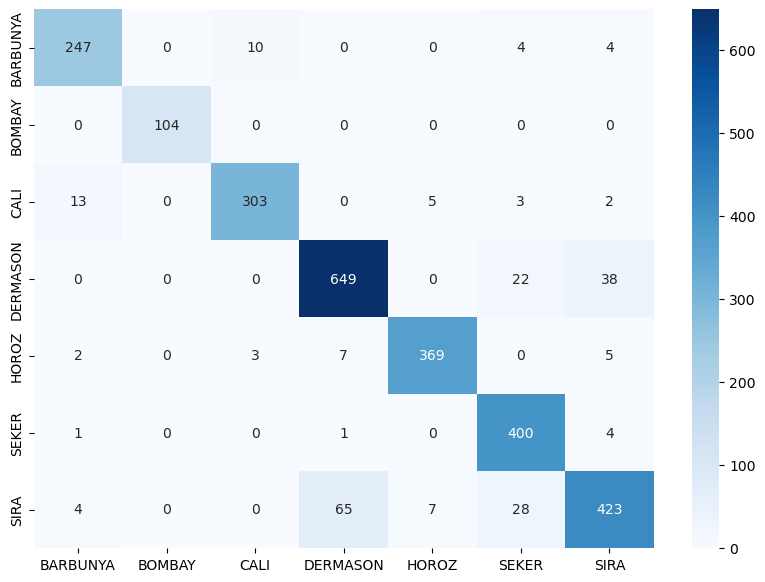

In [17]:
cm = confusion_matrix(y_test, svm_predictions)

# Optionally, visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.savefig('svm_confusion_matrix.png', dpi=300)
plt.show()